In [1]:
!pip install -q --upgrade transformers diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.8 MB/s eta 0:00:00


In [2]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from torchvision import transforms as tfms

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [5]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 88.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [8]:
!pip install rembg[gpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 KB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

pip's dependency 어쩌고 하면서 에러 뜨는데 그냥 잘 돌아간다..

In [9]:
from rembg import remove
import cv2

In [72]:
def gr_magic_mix(input_image, type_prompt, nu=0.95, total_steps=50, guidance_scale=7.5):
  with torch.no_grad():

    #######################################
    # stage 1: remove the background
    input = remove(input_image, alpha_matting=True, alpha_matting_foreground_threshold=200,
                   alpha_matting_background_threshold=50, alpha_matting_erode_size=1)
    trans_mask = input[:,:,3] == 0
    input_image = input.copy()[:,:,:3]
    input_image[trans_mask] = [255, 255, 255]


    #######################################
    # stage 2: semangic mixing
    scheduler.set_timesteps(total_steps)
    # Define the details of the two phases. The first phase generates the rough layout, the second phase fine-tunes towards the prompt.
    t_min = round(0.3 * total_steps)
    t_max = round(0.6 * total_steps)
    layout_steps = list(range(total_steps - t_max, total_steps - t_min))
    fine_tune_steps = list(range(total_steps - t_min, total_steps))

    # Get embeddings for the text prompt
    prompt = f"A cute illustration of {type_prompt} type pokemon"
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""], padding="max_length", max_length=max_length, return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    encoded = pil_to_latent(input_image)
    noise = torch.randn_like(encoded)
    fine_tuned = None

    # First phase: generate the rough layout by interpolating the original image with denoising from the prompt
    for i in layout_steps:
      t = scheduler.timesteps[i]
      noisy_latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([t]))
      if fine_tuned is not None:
        noisy_latents = nu * fine_tuned + (1-nu) * noisy_latents
      model_input = torch.cat([noisy_latents] * 2) 
      model_input = scheduler.scale_model_input(model_input, t)

      noise_pred = unet(model_input, t, encoder_hidden_states=text_embeddings).sample

      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      fine_tuned = scheduler.step(noise_pred, t, noisy_latents).prev_sample

    after_layout = fine_tuned

    # Second phase: fine-tune towards the prompt
    for i in fine_tune_steps:
      t = scheduler.timesteps[i]
      model_input = torch.cat([fine_tuned] * 2)
      model_input = scheduler.scale_model_input(model_input, t)

      noise_pred = unet(model_input, t, encoder_hidden_states=text_embeddings).sample

      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      fine_tuned = scheduler.step(noise_pred, t, fine_tuned).prev_sample

  return latents_to_pil(fine_tuned)[0]

### 삽질의 기록

In [70]:
input_path = 'goldfish.jpg'
output_path = 'goldfish_output7.jpg'

input = cv2.imread(input_path)
output = remove(input, alpha_matting=True, alpha_matting_foreground_threshold=200,  alpha_matting_background_threshold=50,
                alpha_matting_erode_size=1)
trans_mask = output[:,:,3] == 0
output_c = output.copy()[:,:,:3]
output_c[trans_mask] = [255, 255, 255]

cv2.imwrite(output_path, output_c)

# input_path = 'goldfish.jpg'
# output_path = 'goldfish_output.jpg'

# input = Image.open(input_path)
# output = remove(input)
# output.convert("RGB").save(output_path)

True

In [71]:
output_c.shape

(440, 595, 3)

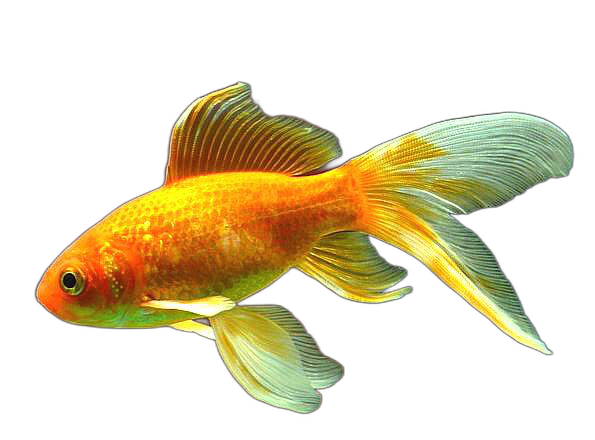

In [37]:
output

In [19]:
input2 = cv2.imread('flying squirrel.png')
input2.shape

(538, 836, 3)

### 어쨌든 돌아간다!

In [73]:
import gradio as gr

demo = gr.Interface(
    fn=gr_magic_mix,
    inputs=[gr.Image(shape=(512, 512)), gr.Textbox(lines=1, placeholder="Pokemon Type")],
    outputs=["image"]
)
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b270276c-ef86-416f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b270276c-ef86-416f.gradio.live
